In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
from pathlib import Path

In [2]:
# 📥 Load processed data
processed_path = Path("../data/processed")
files = list(processed_path.glob("*.parquet"))

dfs = []
for file in files:
    df = pd.read_parquet(file)
    df["ticker"] = file.stem.replace("_PA", "")
    dfs.append(df)

In [8]:
# 🗂️ Combine into one dataframe for EDA
df_all = pd.concat(dfs, ignore_index=True)
if isinstance(df_all.columns, pd.MultiIndex):
    df_all.columns = ["_".join(col).strip() for col in df_all.columns.values]
print(df_all.columns)
print(df_all.head())

Index(['('Close', 'EWLD.PA')', '('High', 'EWLD.PA')', '('Low', 'EWLD.PA')',
       '('Open', 'EWLD.PA')', '('Volume', 'EWLD.PA')', '('daily_return', '')',
       '('weekly_return', '')', '('monthly_return', '')',
       '('rolling_volatility_21', '')', '('rolling_volatility_63', '')',
       '('momentum_21', '')', '('momentum_63', '')', '('ma_21', '')',
       '('ma_63', '')', '('drawdown', '')', 'ticker', '('Close', 'PAEEM.PA')',
       '('High', 'PAEEM.PA')', '('Low', 'PAEEM.PA')', '('Open', 'PAEEM.PA')',
       '('Volume', 'PAEEM.PA')', '('Close', 'ESE.PA')', '('High', 'ESE.PA')',
       '('Low', 'ESE.PA')', '('Open', 'ESE.PA')', '('Volume', 'ESE.PA')',
       '('Close', 'CW8.PA')', '('High', 'CW8.PA')', '('Low', 'CW8.PA')',
       '('Open', 'CW8.PA')', '('Volume', 'CW8.PA')'],
      dtype='object')
   ('Close', 'EWLD.PA')  ('High', 'EWLD.PA')  ('Low', 'EWLD.PA')  \
0             30.896629            30.974160           30.813136   
1             31.057653            31.112322      

In [13]:
print(df_all.columns.tolist())

["('Close', 'EWLD.PA')", "('High', 'EWLD.PA')", "('Low', 'EWLD.PA')", "('Open', 'EWLD.PA')", "('Volume', 'EWLD.PA')", "('daily_return', '')", "('weekly_return', '')", "('monthly_return', '')", "('rolling_volatility_21', '')", "('rolling_volatility_63', '')", "('momentum_21', '')", "('momentum_63', '')", "('ma_21', '')", "('ma_63', '')", "('drawdown', '')", 'ticker', "('Close', 'PAEEM.PA')", "('High', 'PAEEM.PA')", "('Low', 'PAEEM.PA')", "('Open', 'PAEEM.PA')", "('Volume', 'PAEEM.PA')", "('Close', 'ESE.PA')", "('High', 'ESE.PA')", "('Low', 'ESE.PA')", "('Open', 'ESE.PA')", "('Volume', 'ESE.PA')", "('Close', 'CW8.PA')", "('High', 'CW8.PA')", "('Low', 'CW8.PA')", "('Open', 'CW8.PA')", "('Volume', 'CW8.PA')"]


In [21]:
# 📊 Quick EDA
print(df_all.describe())
sns.pairplot(df_all.select_dtypes(include=np.number))
plt.show()

       Close_EWLD.PA  High_EWLD.PA  Low_EWLD.PA  Open_EWLD.PA  Volume_EWLD.PA  \
count            0.0           0.0          0.0           0.0             0.0   
mean             NaN           NaN          NaN           NaN             NaN   
std              NaN           NaN          NaN           NaN             NaN   
min              NaN           NaN          NaN           NaN             NaN   
25%              NaN           NaN          NaN           NaN             NaN   
50%              NaN           NaN          NaN           NaN             NaN   
75%              NaN           NaN          NaN           NaN             NaN   
max              NaN           NaN          NaN           NaN             NaN   

       daily_return  weekly_return  monthly_return  rolling_volatility_21  \
count           0.0            0.0             0.0                    0.0   
mean            NaN            NaN             NaN                    NaN   
std             NaN            NaN     

In [14]:
print(type(df_all.columns[0]))
print(df_all.columns[:5])

<class 'str'>
Index(['('Close', 'EWLD.PA')', '('High', 'EWLD.PA')', '('Low', 'EWLD.PA')',
       '('Open', 'EWLD.PA')', '('Volume', 'EWLD.PA')'],
      dtype='object')


In [15]:
def clean_column_name(col):
    if col.startswith("(") and col.endswith(")"):
        col = col[1:-1]  # remove outer parentheses
        parts = col.split(",")
        parts = [p.strip().strip("'") for p in parts]
        return "_".join([p for p in parts if p])
    return col


df_all.columns = [clean_column_name(col) for col in df_all.columns]

In [22]:
print(df_all.columns[:10].tolist())

['Close_EWLD.PA', 'High_EWLD.PA', 'Low_EWLD.PA', 'Open_EWLD.PA', 'Volume_EWLD.PA', 'daily_return', 'weekly_return', 'monthly_return', 'rolling_volatility_21', 'rolling_volatility_63']


In [23]:
# 🎯 Define target
df_all["target"] = (
    df_all["Close_EWLD.PA"].pct_change(30).shift(-30)
)  # 30-day forward return

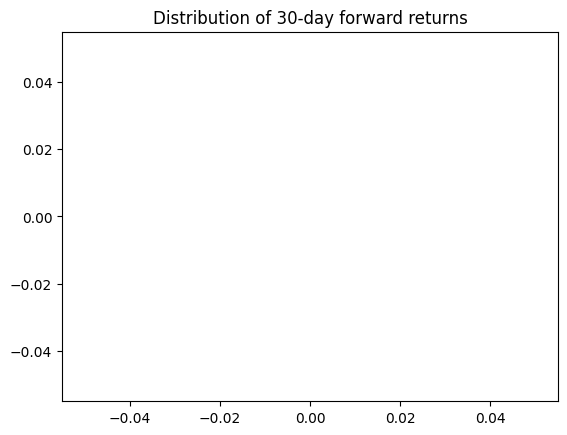

In [24]:
sns.histplot(df_all["target"].dropna(), bins=50)
plt.title("Distribution of 30-day forward returns")
plt.show()

In [18]:
# Drop NaNs created by pct_change and shift
df_all = df_all.dropna().reset_index(drop=True)

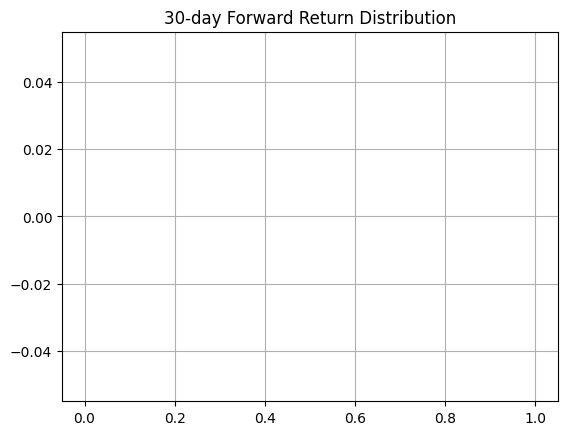

In [19]:
# 📈 Visualize target
df_all["target"].hist(bins=50)
plt.title("30-day Forward Return Distribution")
plt.show()

In [20]:
# 🚂 Prepare features & target
features = ["open", "high", "low", "close", "volume"]
X = df_all[features]
y = df_all["target"]

KeyError: "None of [Index(['open', 'high', 'low', 'close', 'volume'], dtype='object')] are in the [columns]"

In [ ]:
# ⏳ TimeSeriesSplit Cross-validation
tscv = TimeSeriesSplit(n_splits=5)
model = RandomForestRegressor(n_estimators=50, random_state=42)
scores = cross_val_score(model, X, y, cv=tscv, scoring="neg_root_mean_squared_error")

print(f"Cross-validated RMSE: {-np.mean(scores):.4f} +/- {np.std(scores):.4f}")

# 🔍 Train on full dataset & show feature importances
model.fit(X, y)
importances = pd.Series(model.feature_importances_, index=features)
importances.sort_values().plot(kind="barh")
plt.title("Feature Importances")
plt.show()